In [1]:
import os
import gc
import time
from time import gmtime, strftime

from sklearn.model_selection import train_test_split
import lightgbm as lgb
import xgboost as xgb
import numpy as np
import pandas as pd
%matplotlib inline

# Features

In [2]:
def count_agg(df, group_cols):
    col_name = "_".join(group_cols)+'_count'
    count = df.groupby(group_cols).size().reset_index(name=col_name)
    df = df.merge(count, on=group_cols, how='left')
    del count
    gc.collect()
    return df

def count_cum(df, group_cols):
    col_name = "_".join(group_cols)+'_countAccum'
    df[col_name] = df.groupby(group_cols).cumcount()
    gc.collect()
    return df

def count_uniq(df, group_cols, uniq_col):
    col_name = "_".join(group_cols)+'_uniq_'+uniq_col+'_countUniq'
    tmp = df.groupby(group_cols)[uniq_col].nunique().reset_index(name=col_name)
    df = df.merge(tmp, on=group_cols, how='left')
    del tmp
    gc.collect()
    return df

def next_click(df, group_cols):
    df["_".join(group_cols)+'_nextClick'] = (df.groupby(group_cols).click_time.shift(-1) - df.click_time).astype(np.float32)
    gc.collect()
    return df

In [3]:
def generate_features(df):
    print('generating time features...')
    df['day'] = df['click_time'].dt.day.astype('uint8')
    df['hour'] = df['click_time'].dt.hour.astype('uint8')
    df['in_test_hh'] = (3
                        - 2 * df['hour'].isin([4, 5, 9, 10, 13, 14]) # most frequent
                        - 1 * df['hour'].isin([6, 11, 15])).astype('uint8') # least frequent
    print('done')
    gc.collect()
    
    count_combinations = [
        ['app'],
        ['ip', 'device'], # 9.88
        ['day', 'hour', 'app'], # 4.08
        ['ip'], # 3.03
        ['app', 'channel'], # 2.8
        ['ip', 'day', 'in_test_hh'], # 1.74
        ['os', 'app', 'channel'], # 0.72
        ['ip', 'day', 'hour'], # 0.52
        ['os', 'device'], # 0.44
        ['ip', 'os', 'day', 'hour'], # 0.41
        ['ip', 'app', 'day', 'hour'], # 0.28
        ['ip', 'device', 'day', 'hour'], # 0.31
        ['ip', 'app', 'os'] # 0.21
    ]
    
    countUniq_combinations = [
        [['ip'], 'channel'], # 0.9
        [['ip'], 'app'], # 1.3
        [['ip'], 'os'] # 0.45
    ]
    
    nextClick_combinations = [
        ['ip', 'app', 'device', 'os'],
        ['ip', 'app', 'device', 'os', 'channel'],
        ['ip', 'os', 'device'],
        ['ip', 'os', 'device', 'app']
    ]

    # count features
    for i, cols in enumerate(count_combinations):
        print(i, cols)
        df = count_agg(df, cols)

    # count unique features
    for i, cols in enumerate(countUniq_combinations):
        print(i, cols)
        df = count_uniq(df, cols[0], cols[1])
    
    # next click features
    df['click_time'] = (df['click_time'].astype(np.int64) // 10 ** 9).astype(np.int32)
    for i, cols in enumerate(nextClick_combinations):
        print(i, cols)
        df = next_click(df, cols)
    
    df.drop(['ip', 'click_time', 'day', 'in_test_hh'], axis=1, inplace=True)
    gc.collect()
    print(df.info())
    return df

# Load Data

In [4]:
dtype = {
    'ip' :'uint32',
    'app' :'uint16',
    'device': 'uint16',
    'os' :'uint16',
    'channel': 'uint16',
    'is_attributed': 'uint8',
    'click_id': 'uint32',
}

# train: (184903890, 7)
# test: (18790469, 7)
train_cols = ['ip', 'app', 'device', 'os', 'channel', 'click_time', 'is_attributed']
train_df = pd.read_csv('data/train.csv', skiprows=range(1, 84903891), nrows=100000000,
                       dtype=dtype, usecols=train_cols, parse_dates=['click_time'])

test_cols = ['ip', 'app', 'device', 'os', 'channel', 'click_time', 'click_id']
# using test_supplement 
test_df = pd.read_csv('data/test_supplement.csv', dtype=dtype, usecols=test_cols, parse_dates=['click_time'])

In [5]:
# combine train and test data
common_cols = ['ip', 'app', 'device', 'os', 'channel', 'click_time']
all_df = pd.concat([train_df[common_cols], test_df[common_cols]])

In [6]:
# generate data
all_df = generate_features(all_df)

generating time features...
done
0 ['app']
1 ['ip', 'device']
2 ['day', 'hour', 'app']
3 ['ip']
4 ['app', 'channel']
5 ['ip', 'day', 'in_test_hh']
6 ['os', 'app', 'channel']
7 ['ip', 'day', 'hour']
8 ['os', 'device']
9 ['ip', 'os', 'day', 'hour']
10 ['ip', 'app', 'day', 'hour']
11 ['ip', 'device', 'day', 'hour']
12 ['ip', 'app', 'os']
0 [['ip'], 'channel']
1 [['ip'], 'app']
2 [['ip'], 'os']
0 ['ip', 'app', 'device', 'os']
1 ['ip', 'app', 'device', 'os', 'channel']
2 ['ip', 'os', 'device']
3 ['ip', 'os', 'device', 'app']
<class 'pandas.core.frame.DataFrame'>
Int64Index: 157537505 entries, 0 to 157537504
Data columns (total 25 columns):
app                                   uint16
device                                uint16
os                                    uint16
channel                               uint16
hour                                  uint8
app_count                             int64
ip_device_count                       int64
day_hour_app_count                    int64
i

In [7]:
# split train/test features from concated data
train_features = all_df.iloc[:train_df.shape[0]]
test_features = all_df.iloc[train_df.shape[0]:]
gc.collect()

24

# Train LightGBM Model

In [ ]:
metrics = 'auc'
lgb_params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': metrics,
    'learning_rate': 0.1,
    'num_leaves': 7,
    'max_depth': 4,
    'min_child_samples': 100,
    'max_bin': 100,
    'subsample': 0.7,
    'subsample_freq': 1,
    'colsample_bytree': 0.7,
    'min_child_weight': 0,
    'min_split_gain': 0,
    'nthread': 24,
    'verbose': 1,
    'scale_pos_weight': 200
}

target = 'is_attributed'
features = [col for col in train_features.columns if col not in ['is_attributed']]
category = ['app', 'device', 'os', 'channel', 'hour']

In [ ]:
# train valid split
labels = train_df.is_attributed.values
train_features, valid_features = train_test_split(train_features, train_size=.95, shuffle=False)
train_labels, valid_labels = train_test_split(labels, train_size=.95, shuffle=False)
print('Train size:', len(train_features))
print('Valid size:', len(valid_features))
gc.collect()

In [ ]:
# convert data into dataset. Warning: Memory Peak
xgtrain = lgb.Dataset(train_features[features].values, 
                      label=train_labels,
                      feature_name=features,
                      categorical_feature=category)

In [ ]:
xgvalid = lgb.Dataset(valid_features[features].values, 
                      label=valid_labels,
                      feature_name=features,
                      categorical_feature=category)

In [ ]:
print('Training...')
evals_results = {}
model = lgb.train(lgb_params,
                  xgtrain,
                  valid_sets=[xgvalid],
                  valid_names=['valid'],
                  evals_result=evals_results,
                  num_boost_round=1000,
                  early_stopping_rounds=50,
                  verbose_eval=1,
                  feval=None)
n_estimators = model.best_iteration

print('\nModel Info:')
print('n_estimators:', n_estimators)
print(metrics + ':', evals_results['valid'][metrics][n_estimators - 1])

gain = model.feature_importance('gain')
ft = pd.DataFrame({'feature': model.feature_name(), 'split': model.feature_importance('split'),
                   'gain': 100 * gain / gain.sum()}).sort_values('gain', ascending=False)
ft.to_csv('feature_importance_ref.csv', index=False)
print(ft)

model_name = 'model-%s' % strftime("%Y-%m-%d-%H-%M-%S", gmtime())
model.save_model(model_name)
print('model saved as %s' % model_name)

# LGB Prediction

In [ ]:
print('Predicting...')
test_df['is_attributed'] = model.predict(test_features[features], num_iteration=model.best_iteration)

In [ ]:
print('loading test')
test = pd.read_csv('data/test.csv', dtype=dtype, usecols=test_cols, parse_dates=['click_time'])

In [ ]:
print('merging test_supplement to test')
join_cols = ['ip', 'app', 'device', 'os', 'channel', 'click_time']
all_cols = join_cols + ['is_attributed']

test = test.merge(test_df[all_cols], how='left', on=join_cols)
test = test.drop_duplicates(subset=['click_id'])

print("Writing the submission data into a csv file...")
test[['click_id', 'is_attributed']].to_csv('submit_lgb.gz', index=False, float_format='%.9f', compression='gzip')
print("All done...")

In [ ]:
#model = lgb.Booster(model_file='model-2018-05-03-09-35-27')
#submit['is_attributed'] = model.predict(test_df[features], num_iteration=616)

In [ ]:
del xgtrain
del xgvalid
gc.collect()

# Train XGBoost

In [8]:
xgb_params = {'eta': 0.1,
              'tree_method': "hist",
              'grow_policy': "lossguide",
              # 'max_leaves': 1400,  
              'max_depth': 4, 
              'subsample': 0.7, 
              'colsample_bytree': 0.7, 
              'colsample_bylevel':0.7,
              'min_child_weight':0,
              'alpha':0,
              'objective': 'binary:logistic', 
              'eval_metric': 'auc',
              'nthread':24,
              'random_state': 42,
              'scale_pos_weight':200,
              'silent': True}

In [9]:
# train valid split
labels = train_df.is_attributed.values
train_features, valid_features = train_test_split(train_features, train_size=.95, shuffle=False)
train_labels, valid_labels = train_test_split(labels, train_size=.95, shuffle=False)
print('Train size:', len(train_features))
print('Valid size:', len(valid_features))
gc.collect()

/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Train size: 95000000
Valid size: 5000000


12

In [ ]:
# xgb will handle dataframe directly, great! just tell her which columns are categorial
for col in ['app', 'device', 'os', 'channel', 'hour']:
    train_features[col] = train_features[col].astype('category')
    valid_features[col] = valid_features[col].astype('category')

In [10]:
dtrain = xgb.DMatrix(train_features, train_labels)
dvalid = xgb.DMatrix(valid_features, valid_labels)
watchlist = [(dvalid, 'valid')]

In [12]:
xgb_model = xgb.train(xgb_params, 
                      dtrain, 
                      num_boost_round=2000, 
                      evals=watchlist, 
                      maximize=True, 
                      early_stopping_rounds = 50, 
                      verbose_eval=5)

[0]	valid-auc:0.958325
Will train until valid-auc hasn't improved in 50 rounds.
[5]	valid-auc:0.965192
[10]	valid-auc:0.96783
[15]	valid-auc:0.971056
[20]	valid-auc:0.972209
[25]	valid-auc:0.973376
[30]	valid-auc:0.974533
[35]	valid-auc:0.976185
[40]	valid-auc:0.978193
[45]	valid-auc:0.979578
[50]	valid-auc:0.980908
[55]	valid-auc:0.981792
[60]	valid-auc:0.982481
[65]	valid-auc:0.98312
[70]	valid-auc:0.98367
[75]	valid-auc:0.984076
[80]	valid-auc:0.984599
[85]	valid-auc:0.98491
[90]	valid-auc:0.985202
[95]	valid-auc:0.985609
[100]	valid-auc:0.98581
[105]	valid-auc:0.986106
[110]	valid-auc:0.986383
[115]	valid-auc:0.986489
[120]	valid-auc:0.986609
[125]	valid-auc:0.986828
[130]	valid-auc:0.987012
[135]	valid-auc:0.987121
[140]	valid-auc:0.987194
[145]	valid-auc:0.987355
[150]	valid-auc:0.987469
[155]	valid-auc:0.987521
[160]	valid-auc:0.987629
[165]	valid-auc:0.987704
[170]	valid-auc:0.987751
[175]	valid-auc:0.987793
[180]	valid-auc:0.987916
[185]	valid-auc:0.987954
[190]	valid-auc:0.98

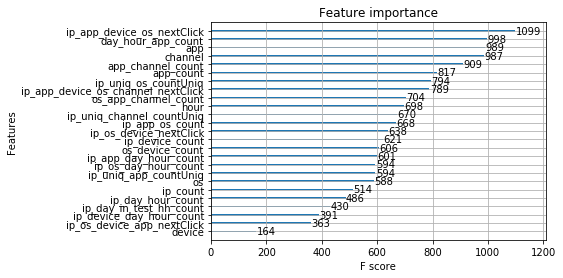

In [13]:
xgb.plot_importance(xgb_model)

In [14]:
xgb_model.best_score 

0.989928

# XGB Prediction

In [15]:
model_name = 'xgb-model-%s' % strftime("%Y-%m-%d-%H-%M-%S", gmtime())
xgb_model.save_model(model_name)
print('model saved as %s' % model_name)

model saved as xgb-model-2018-05-04-15-18-29


In [16]:
dtest = xgb.DMatrix(test_features)

In [17]:
print('Predicting...')
test_df['is_attributed'] = xgb_model.predict(dtest, ntree_limit=xgb_model.best_ntree_limit)

Predicting...


In [18]:
print('loading test')
test = pd.read_csv('data/test.csv', dtype=dtype, usecols=test_cols, parse_dates=['click_time'])

loading test


In [19]:
print('merging test_supplement to test')
join_cols = ['ip', 'app', 'device', 'os', 'channel', 'click_time']
all_cols = join_cols + ['is_attributed']

test = test.merge(test_df[all_cols], how='left', on=join_cols)
test = test.drop_duplicates(subset=['click_id'])

print("Writing the submission data into a csv file...")
test[['click_id', 'is_attributed']].to_csv('submit_xgb_1065.gz', index=False, float_format='%.9f', compression='gzip')
print("All done...")

merging test_supplement to test
Writing the submission data into a csv file...
All done...
